
Dataset GSM3215435

In [1]:
import numpy as np
import pandas as pd
import scanpy as sc

In [8]:
# Import
adata = sc.read_10x_mtx(
    'data/',  
    var_names='gene_symbols',
    cache=True)          

Filter corrsponding to those used in Kostya's HW

In [10]:
sc.pp.filter_cells(adata, min_genes=20)
sc.pp.filter_genes(adata, min_cells=20)

Annotation by mitochondrial genes presented

In [19]:
adata.var['mt'] = adata.var_names.str.startswith('mt-')  # annotate the group of mitochondrial genes as 'mt'
adata.var['mt'].value_counts()
sc.pp.calculate_qc_metrics(adata, qc_vars=['mt'], percent_top=None, log1p=True, inplace=True)

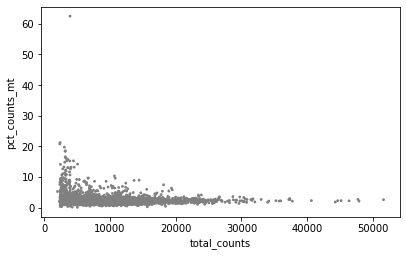

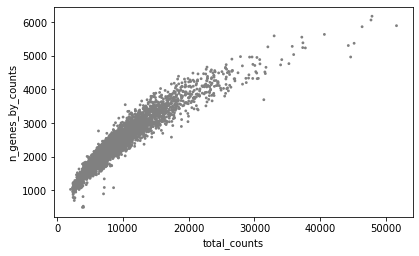

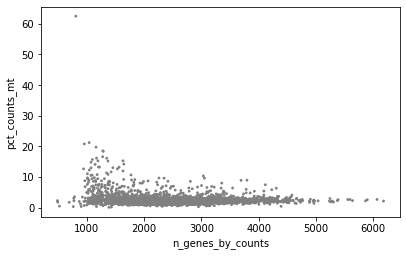

In [20]:
sc.pl.scatter(adata, x='total_counts', y='pct_counts_mt')
sc.pl.scatter(adata, x='total_counts', y='n_genes_by_counts')
sc.pl.scatter(adata, x='n_genes_by_counts', y='pct_counts_mt')

Get rid of cells with mitochondrial genes percentage higher than 5% and nfeature less than 1000


In [32]:
adata = adata[adata.obs.n_genes_by_counts > 1000, :].copy()
adata = adata[adata.obs.pct_counts_mt < 5, :].copy()

Normalization

In [23]:
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])
sc.pp.normalize_total(adata, target_sum=1e4) # Total-count normalize (library-size correct) the data matrix X to 10,000 reads per cell, so that counts become comparable among cells.
sc.pp.log1p(adata) # log-normalization
pd.DataFrame.sparse.from_spmatrix(adata.X[:100, :100])

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0.800045,0.000000,0.000000,0.000000,0.000000,0.800045,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
1,1.438753,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
2,0.000000,0.000000,0.791370,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
3,0.000000,0.000000,1.041044,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
4,0.000000,0.000000,0.000000,1.003354,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
95,0.899842,0.000000,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.899842,0.0,0.0
96,1.327912,0.000000,1.327912,0.000000,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,1.327912,0.0,0.0,0.000000,0.0,0.0
97,1.098346,0.000000,0.000000,0.000000,1.098346,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0
98,0.000000,0.000000,1.232255,0.795016,0.000000,0.000000,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.000000,0.0,0.0,0.000000,0.0,0.0


Find Variable genes

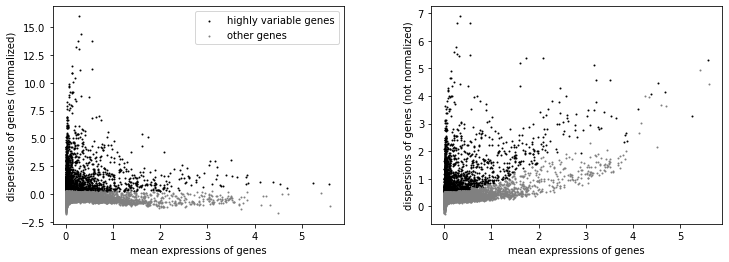

In [30]:
import matplotlib.pyplot as plt
sc.pp.highly_variable_genes(adata,  n_top_genes = 2000, min_mean=0.0125, max_mean=3, min_disp=0.5)
gca = sc.pl.highly_variable_genes(adata, show=False, log=False) # can not scale only x

In [26]:
adata.var['highly_variable'].value_counts()

False    10904
True      1241
Name: highly_variable, dtype: int64

PCA

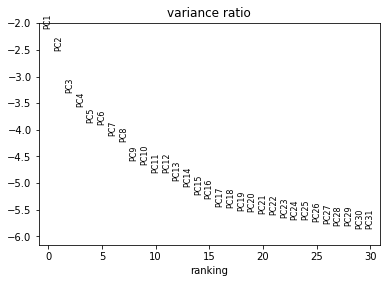

In [31]:
sc.tl.pca(adata, svd_solver='arpack')
sc.pl.pca_variance_ratio(adata, log=True)